# Import Dataset


In [2]:
%run -i "CleanedData.py"

/workspaces/Dq_Datascientist/3 - Data_Cleaning/03_Data_Cleaning_Walktrough/CleanedData.py:67: SyntaxWarning: invalid escape sequence '\('
  y = re.findall("\(.+\)", x)
/workspaces/Dq_Datascientist/3 - Data_Cleaning/03_Data_Cleaning_Walktrough/CleanedData.py:75: SyntaxWarning: invalid escape sequence '\('
  y = re.findall("\(.+\)", x)
/workspaces/Dq_Datascientist/3 - Data_Cleaning/03_Data_Cleaning_Walktrough/CleanedData.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined['school_dist'] = combined['DBN'].apply(lambda x:x[0:2])


In [3]:
combined.head()

,DBN,SCHOOL NAME_x,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lon,lat,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,0.0,0.0,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,-73.98526,40.713764,01
1,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,0.0,0.0,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,-73.98526,40.713764,01
2,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,0.0,0.0,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,-73.98526,40.713764,01
3,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,0.0,0.0,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,-73.98526,40.713764,01
4,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,0.0,0.0,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,-73.98526,40.713764,01


# 1) Introduction

we began investigating possible relationships between SAT scores and demographics. In order to do this, we acquired several datasets containing information about **New York City public schools**. We **cleaned** them, then **combined** them into a single dataset named combined that we're now ready to analyze and visualize.

In this lesson, we'll discover correlations, create plots, and then make maps. The first thing we'll do is find any **correlations** between `columns` and `sat_score`.


# 2 - 3) Finding Correlations With the r Value

We'll be using the **r value**, also called Pearson's correlation coefficient, to measure how closely two sequences of numbers are correlated.

An **r value** falls between `-1` and `1`. The value determines whether two columns are:

* positively correlated;
* not correlated;
* or negatively correlated.

The closer to `1` the **r value** is, the stronger the positive correlation between the two columns. The closer to `-1` the **r value** is, the stronger the negative correlation (i.e., the more "opposite" the columns are). The closer to `0`, the weaker the correlation.

In general, r values above `.25` or below `-.25` are enough to qualify a correlation as interesting.

We can use the pandas `pandas.DataFrame.corr()` method to find correlations between columns in a dataframe. The method returns a new dataframe where the index for each column and row is the name of a column in the original dataset.

# Instructions

1. Use the `pandas.DataFrame.corr()` method on the combined dataframe to find all possible correlations. Assign the result to correlations.
    * Ensure you use the `numeric_only=True` argument to only return the correlations between numeric columns.

1. Filter correlations so that it only shows correlations for the column `sat_score`.
1. Display all of the rows in correlations and examine them.

In [4]:
correlations = combined.corr(numeric_only=True)['sat_score']
print(correlations)

SAT Critical Reading Avg. Score    0.995822
SAT Math Avg. Score                0.990895
SAT Writing Avg. Score             0.995898
sat_score                          1.000000
AP Test Takers                     0.392718
                                     ...   
Census Tract                       0.060592
BIN                                0.069487
BBL                                0.072702
lon                               -0.057324
lat                               -0.072652
Name: sat_score, Length: 74, dtype: float64


# 4 - 5) Plotting Enrollment With the Plot() Accessor

Unsurprisingly, `SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score` are strongly correlated with `sat_score`.

We can also make some other observations:

1. `total_enrollment` has a strong positive correlation with sat_score. In order words, larger schools tend to do better on the SAT.

    * Other columns that are proxies for **enrollment** correlate similarly. These include `total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS`.

1. Both the percentage of females (`female_per`) and number of females (`female_num`) at a school correlate **positively** with SAT score, whereas the percentage of males (`male_per`) and the number of males (`male_num`) correlate **negatively**. This could indicate that women do better on the SAT than men.

1. Teacher and student ratings of **school safety** (`saf_t_11`, and `saf_s_11`) correlate with sat_score.

1. Student ratings of school **academic standards** (`aca_s_11`) correlate with `sat_score`, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).

1. There is significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`).

1. The percentage of students eligible for free or reduced school lunch based on household income (`frl_percent`) has a strong negative correlation with SAT scores.

Since **enrollment** seems to have such a strong correlation, let's make a scatterplot of `total_enrollment` vs `sat_score`. Each point in the scatterplot represents a high school, so we'll be able to see if there are any interesting patterns.

We can plot columns in a dataframe using the [pandas.DataFrame.plot()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) accessor on a dataframe.

We can also specify a certain plot type. For example, `df.plot.scatter(x="A", y="B")` creates a scatterplot of columns A and B.

## Instructions

Create a scatterplot of `total_enrollment` (on the horizontal axis) versus `sat_score` (on the vertical axis).

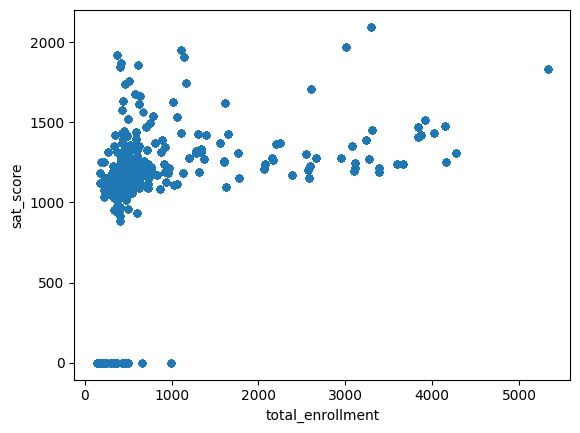

In [5]:
import matplotlib.pyplot as plt

combined.plot.scatter(x="total_enrollment",y="sat_score")
plt.show()


# 6) Exploring Schools with Low SAT Scores and Enrollment

Judging from the plot it was just created, it doesn't appear there's a strong correlation between `sat_score` and `total_enrollment`.

However, there's an interesting cluster of points at the bottom left where `total_enrollment` and `sat_score` are both low. This cluster may be what's making the **r value** so high. It's worth extracting the names of the schools in this cluster so we can research them further.


## Instructions

1. Filter the combined dataframe to keep only those rows where `total_enrollment` is under `1000` and sat_score is under 1000. Assign the result to low_enrollment.

1. Display all of the items in the School Name column of low_enrollment.

1. Use Wikipedia and Google to research the names of the schools. Can you discover anything interesting about them?

In [15]:
low_enrollment = combined[(combined['total_enrollment']<1000) & (combined['sat_score']<1000) & (combined['sat_score']>0)]

print(low_enrollment['School Name'])

2227      INTERNATIONAL COMMUNITY HIGH SCHOOL
2228      INTERNATIONAL COMMUNITY HIGH SCHOOL
2229      INTERNATIONAL COMMUNITY HIGH SCHOOL
2230      INTERNATIONAL COMMUNITY HIGH SCHOOL
2231      INTERNATIONAL COMMUNITY HIGH SCHOOL
                        ...                  
7834    PAN AMERICAN INTERNATIONAL HIGH SCHOO
7835    PAN AMERICAN INTERNATIONAL HIGH SCHOO
7836    PAN AMERICAN INTERNATIONAL HIGH SCHOO
7837    PAN AMERICAN INTERNATIONAL HIGH SCHOO
7838    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, Length: 194, dtype: object


# 7) Plotting Language Learning Percentage

Our research on the last screen revealed that most of the high schools with **low total enrollment** and **low SAT scores** have high percentages of English language learners. This indicates that it's actually `ell_percent` that correlates strongly with `sat_score`, rather than `total_enrollment`. To explore this relationship further, let's plot out `ell_percent` vs `sat_score`.

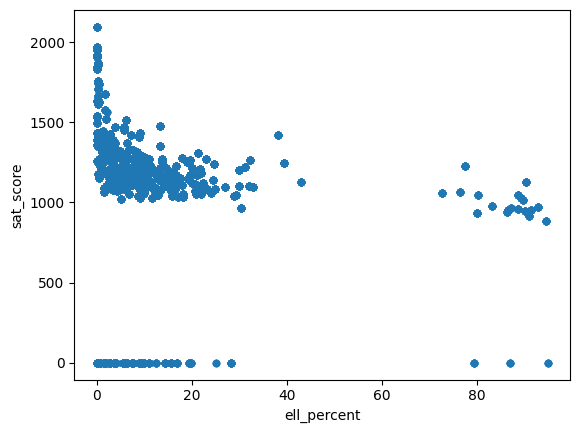

In [16]:
combined.plot.scatter(x="ell_percent",y="sat_score")
plt.show()

# 8)Calculating District-Level Statistics

One way to make very granular statistics easier to read is to aggregate them. In this case, we aggregate by district, which enables us to understand how `ell_percent` varies **district-by-district** instead of the unintelligibly granular **school-by-school** variation.

In a previous lesson, we used the `pandas.DataFrame.groupby()` method followed by the `agg()` method on the resulting object to find the mean class size for each unique `DBN`. The principle is exactly the same, except that here we'd find the mean of each column for each unique value in `school_dist`.

## Instructions

1. Find the average values for each column for each `school_dist` in `combined`.

    * Use the `pandas.DataFrame.groupby()` method to group combined by `school_dist`.
    * Use the `agg()` method with the string 'mean' as an argument to calculate the average of each group. This approach leverages pandas' built-in functionality for better readability and performance.
    * Assign the result to the variable `districts`.

1. Reset the index of districts, making `school_dist` a column again.
    * Use the `pandas.DataFrame.reset_index()` method with the keyword argument `inplace=True`.

1. Display the first few rows of districts to verify that everything went okay.